In [10]:
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm

throughout this code, we will do our best to make it as efficient as possible. however neither of us has a solid programming background so bear with us

# Problem definition

**Problem**: distributing 64 guests across 8 tables (with 8 guests each), maximizing total sum of guest happiness

**Task**: use Genetic Algorithms to solve the problem

**Admissible solution**: a complete seating arrangement, specifying which guests are seated at which table

**Constraints**:
1. Each guest must be assigned to only one table
2. Table placement matters only in terms of grouping (arrangement within a table is irrelevant)
3. Unfeasible solutions (one guest unassigned or in several tables) are invalid and must not be generated

Constraints 1 and 2 define this problem as a **grouping problem**: partitioning a set $U$ of objects into a collection of mutually disjoint subsets $U_i$, i.e. such that the union of all subsets is the original set $U$, and that their intersection is $\empty$.
- Informally, each object must be assigned to 1 and only 1 group.

Constraint 3 is more of a design choice, but a wise one as there is no apparent benefit to incorporating unadmissible solutions that would exponentially bloat the dimension of the search space, making admissible solutions scarce.


In [11]:
df = pd.read_csv("../data/seating_data.csv",index_col=0)
df

,1,2,3,4,5,6,7,8,9,10,...,55,56,57,58,59,60,61,62,63,64
idx,,,,,,,,,,,,,,,,,,,,,
1,0,5000,0,0,700,700,0,0,0,0,...,100,100,0,0,100,100,100,0,0,0
2,5000,0,700,700,0,0,300,300,500,500,...,100,100,0,100,0,0,0,0,0,0
3,0,700,0,2000,0,0,0,0,300,300,...,0,0,0,0,0,0,0,0,0,0
4,0,700,2000,0,0,0,900,400,300,300,...,0,0,0,0,0,0,0,0,0,0
5,700,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60,100,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
61,100,0,0,0,0,0,0,0,0,0,...,0,0,0,0,100,0,0,2000,700,700
62,0,0,0,0,0,0,0,0,0,0,...,0,0,-1000,0,100,0,2000,0,700,700


In [12]:
# mask = np.triu(np.ones_like(df, dtype=bool))  # for lower triangle
# cmap = sns.diverging_palette(10, 130, s=99, as_cmap=True)  # red to green, centered
# plt.figure(figsize=(20, 16))
# sns.heatmap(df, mask=mask, cmap=cmap, center=0, annot=False, fmt=".2f", linewidths=0.5, square=True, cbar_kws={"shrink": 0.75})
# plt.title("Visualization of guest relationships")
# plt.tight_layout()
# plt.show()


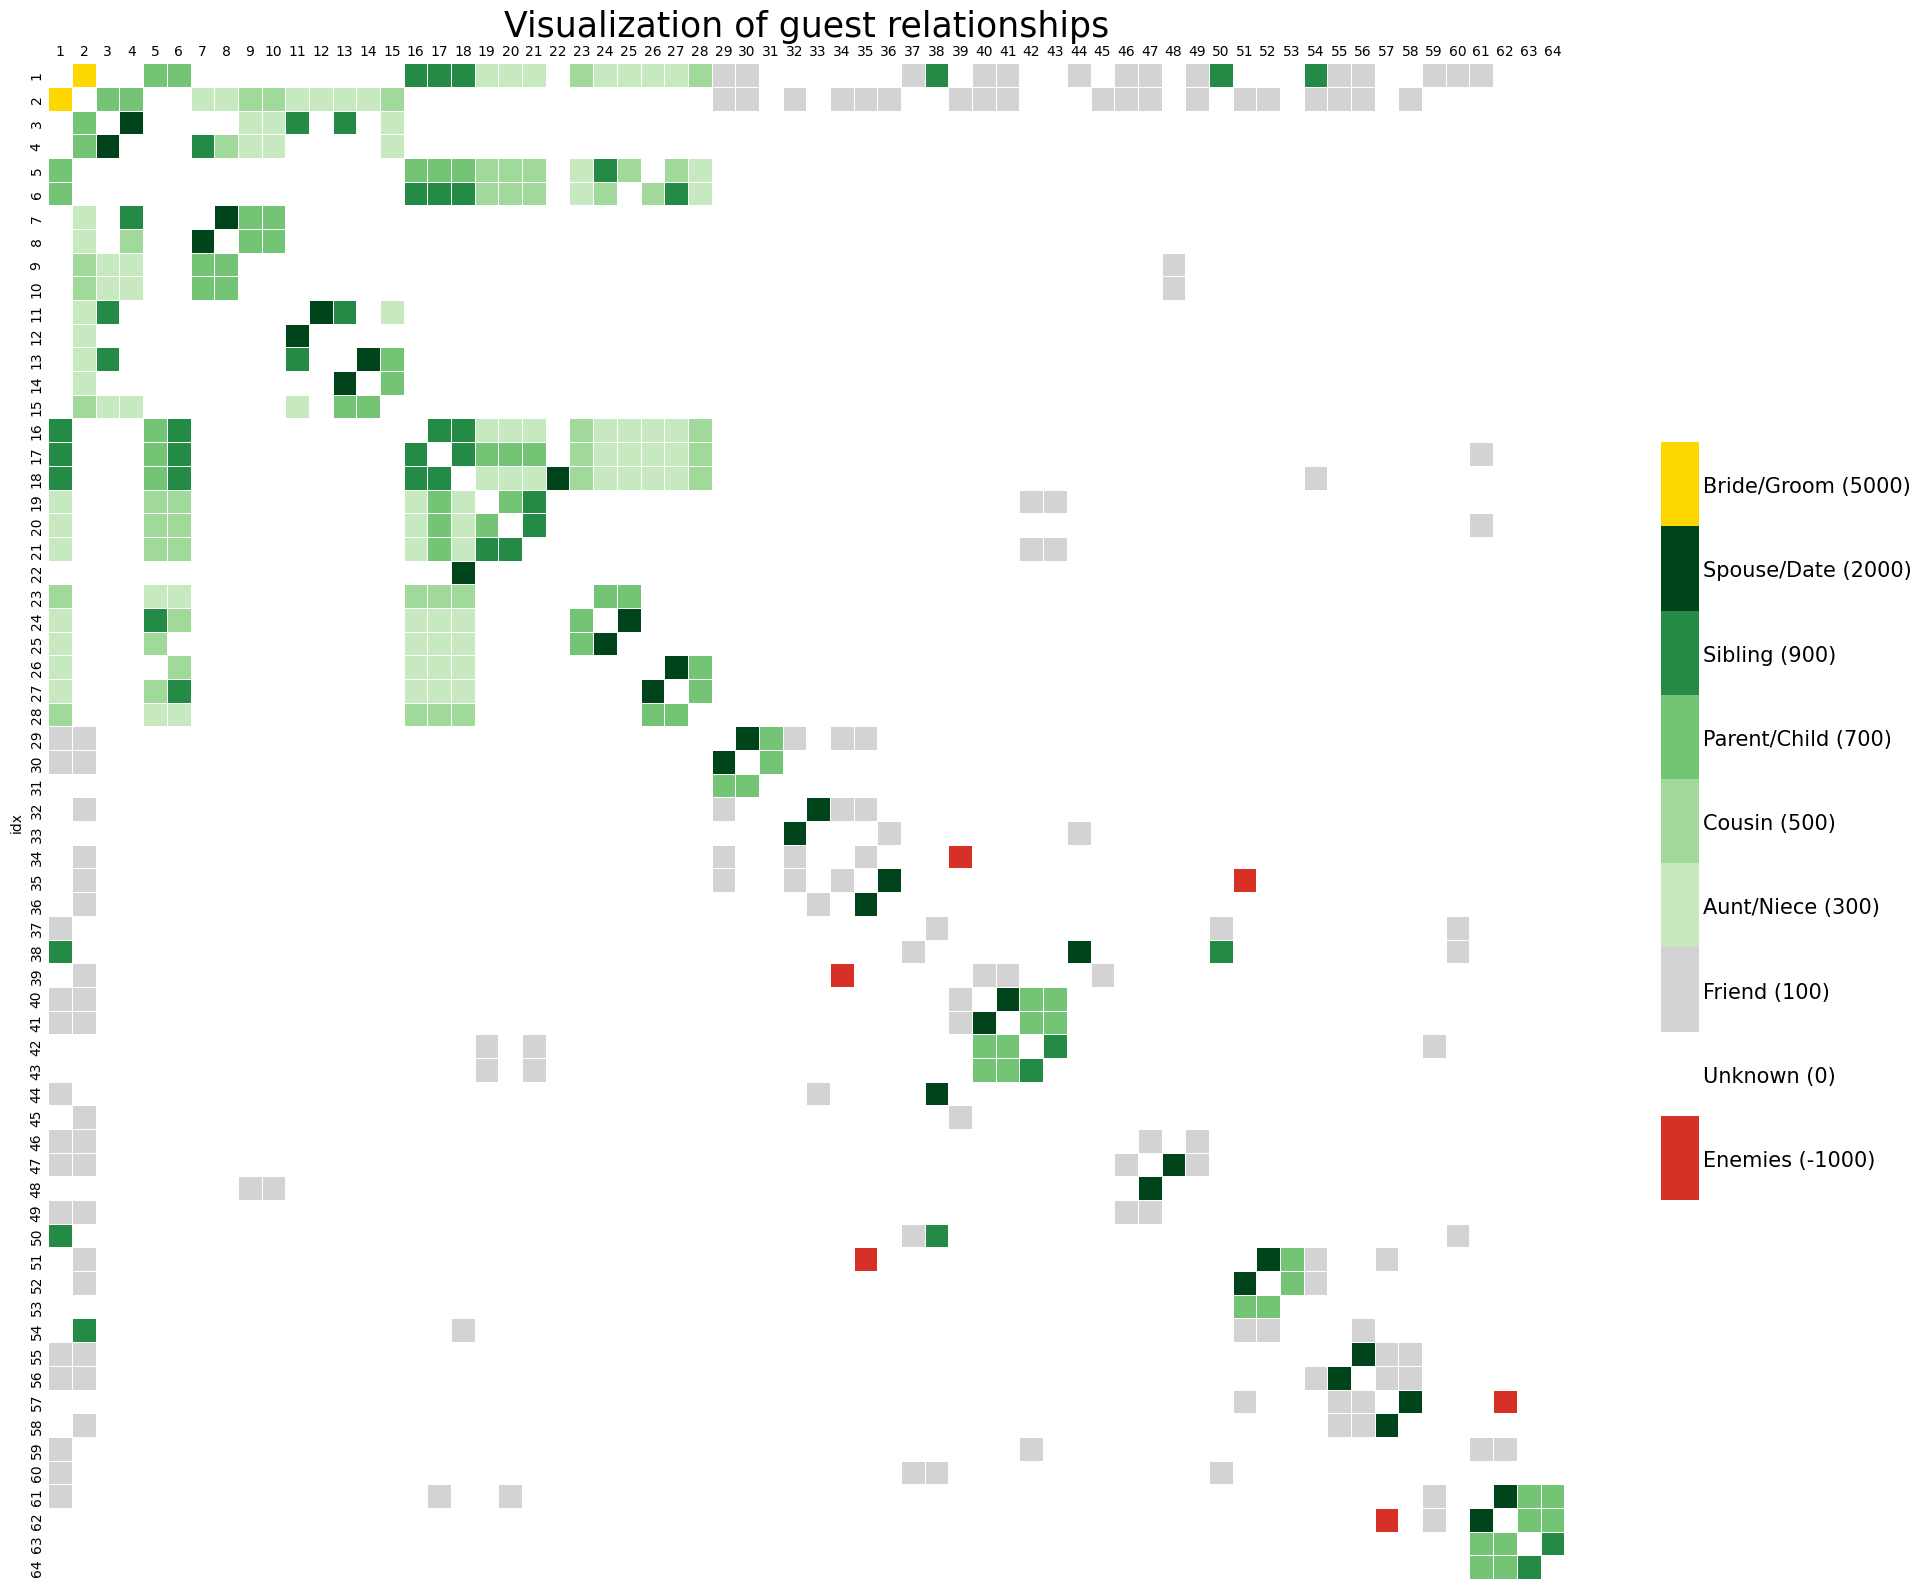

In [ ]:
levels = [-1000, 0, 100, 300, 500, 700, 900, 2000, 5000]
labels = ["Enemies (-1000)", "Unknown (0)", "Friend (100)", "Aunt/Niece (300)", "Cousin (500)", "Parent/Child (700)", "Sibling (900)", "Spouse/Date (2000)", "Bride/Groom (5000)"]
colors = [
    "#d73027",  # enemies (deep red)
    "#ffffff",  # unknown (white)
    "#D3D3D3",  # friend (light gray)
    "#c7e9c0",  # aunt/niece (pale green)
    "#a1d99b",  # cousin (light mint)
    "#74c476",  # parent/child (medium green)
    "#238B45",  # sibling (rich forest green)
    "#00441B",  # spouse/date (very dark green)
    "#FFD700",  # bride/groom (bright gold)
]

cmap = ListedColormap(colors)
# build boundaries halfway between successive levels (as before)
bounds = [levels[0] - 1] + [ (levels[i] + levels[i+1]) / 2 for i in range(len(levels)-1) ] + [levels[-1] + 1]
norm = BoundaryNorm(bounds, cmap.N, clip=True)
midpoints = [ (bounds[i] + bounds[i+1]) / 2 for i in range(len(bounds)-1) ]

plt.figure(figsize=(20,16))
ax = sns.heatmap(df,cmap=cmap,norm=norm,linewidths=0.5,square=True,cbar_kws={"shrink": 0.5,"ticks": midpoints,"format": "%d"})
ax.xaxis.tick_top()
ax.tick_params(axis="x", which="both", length=0)
ax.tick_params(axis="y", which="both", length=0)
cbar = ax.collections[0].colorbar
cbar.set_ticklabels(labels, fontdict = {'fontsize' : 15})
cbar.ax.minorticks_off()
cbar.ax.tick_params(length=0)

plt.title("Visualization of guest relationships", fontdict = {'fontsize' : 25})
plt.tight_layout()
plt.show()


# Contextualization



This problem is an NP-hard problem, thus any exact algorithm that could solve the problem (finding a global optimum) would run in exponential time to the size of the problem instance.

We can calculate the number of possible solutions: (# total ways to arrange guests) / [(# ways to arrange guests in each table)^(#tables) * (# ways to arrange tables)]

$\frac{64!}{8!^8\times 8!} = 450538787986875167583433232345723106006796340625 \approx 4.51 \times 10^{47}$

GPT o4-mini-high estimates it takes 0.03ms at best to compute the fitness of one individual, meaning approximately $4.3 \times 10^{35}$ years to brute-force all possible solutions. If we compare the age of the universe (13.79 billion) to the weight of a paperclip, then the time it would take to compute all fitnesses would be equivalent to the weight of Jupiter.

Definitely there would be a smarter way to try and brute-force the global optimum, but it would definitely still be many orders of magnitude above (currently?) humanly possible

---

Falkenauer, E. (1996). The Grouping Genetic Algorithm. In: Floudas, C.A., Pardalos, P.M. (eds) State of the Art in Global Optimization. Nonconvex Optimization and Its Applications, vol 7. Springer, Boston, MA. https://doi.org/10.1007/978-1-4613-3437-8_17

Since the 90s that it's known that GAs are promising for NP-hard problems, leading to their use in grouping problems as well (Falkenauer, 1996)

# Representation

Notation
- $t$, number of tables
- $m$, table size (people per table)
- $n = tm$, total number of people

Let's imagine there's 6 people, numbered 1-6, and 2 tables. ($t=2, m=3, n=6$)

Example instance: Table 1: 1,3,5; Table 2: 2,4,6



Manual brainstorming ideas for representations:
1. **Table lists** (one list for the individuals in each table): `[[1,3,5], [2,4,6]]`
2. **Index's table number** (which table each individual belongs to): `[1,2,1,2,1,2]` (or `'121212'`)
3. **Binary index's table number** (which table each individual belongs to, but binary encoded): `[[1,0],[0,1],[1,0],[0,1],[1,0],[0,1]]`
4. **Binary table lists** (indicating which individuals belong to each table): `[[1,0,1,0,1,0], [0,1,0,1,0,1]]`

The binary ones were discarded as we couldn't identify apparent benefits compared to their non-binary counterpart, while they would complexify the code logic

### Literature review



Radcliffe, N. J. (1991, July). Forma Analysis and Random Respectful Recombination. In Icga (Vol. 91, pp. 222-229). https://stochasticsolutions.com/pdf/icga91.pdf

Radcliffe mentions six design principles for constructing useful representations:
1. Minimal redundancy: each member of the search space should be represented by only one chromosome (representation), in order to reduce the size of the search space the GA has to search

The rest are abstract enough that I currently cannot comprehend them or have the energy to properly read through the paper although it looks extremely interesting and are probably not relevant enough

---

Falkenauer

>Application of a straightforward encoding scheme together with standard genetic operators (Holland (1975)) is the first route that has been taken in the GA literature treating grouping problems, e.g. by Van Driessche and Piessens (1992), Ding et al. (1992), Jones and Beltramo (1991). We will show why we think **this is not the best GA approach for these problems**. 

Falkenauer raises the following problems:

1. **Encoding and redundancy**: straightforward encoding schemes, as the ones above, are redundant, going against the minimal redundancy principle suggested by Radcliffe. Idea (2) suffers from this as both individuals `121212` and `212121` represent the same real-world solution: guests 1,3,5 being seated in one table and guests 2,4,6 in another - meaning that in our instance each solution would have $8! = 40320$ different representations. Idea (1) suffers from this exact problem as well, and additionally the one of intra-table arrangement, meaning that each solution in our instance would have $8!^8\times 8! = 8!^9 \approx 2.82 \times 10^{41}$ different solutions, which is absurd, especially when considering the already uncomprehensibly high number of possible solutions previously mentioned.
2. **Context insensitivity of crossover**: consider 2 parents: `1|223|13` and `3|112|32`. Subject to standard two-point crossover, they would yield `111213`. Not only is the child "illegal" (raising the problem of incompatibility with several operators we've studied), but there's also a deeper underlying issue: both parents encode the same solution. It is expected that a recombination operator for 2 identical parents should yield identical offspring; however, it is clear that the child produced is completely different to the parents.

Falkenauer further criticizes the use of standard genetic operators.

Falkenauer then mentions other work using more "intelligent" operators better adapted to these grouping problems (ones that would take into consideration the groupings and be less disruptive). Although acknowledging the improvement, they comment:

>"For even if a crossover operator is well adapted to a problem, it cannot alone draw the maximum benefit from the GA technique, i.e. if it is not supported by an encoding adapted to the problem. Indeed, Muhlenbein himself observes that "The genetic representation [he uses] does not capture the structure of the problem."

and goes on to mention their own suggestion, the Grouping Genetic Algorithm.

### Decision

However, we will stay on the level of using a standard representation, like the ones we initially brainstormed, but consider sensible operators that could lead to good results.


|Format|Representation|# Representations for 1 solution|Pros|Cons|
|:--|:--:|:--:|--|--|
|Lists of individuals per table| `[[1,3,5], [2,4,6]]`|$8!^9 \approx 2.82 \times 10^{41}$|Intuitive| (A lot) More redundant|
|Individual's table number| `[1,2,1,2,1,2]`|$8! = 40320$|Less intuitive|Less redundant|

We believe that most relevant problems, such as incompatibility with many crossover operators, are present for both representations. So, our decision was based on the above comparison -- deciding on the 2nd option, as it is significatively less redundant (although we will use operators where that likely would make little difference).


# Implementation

To-do (obligatory code):

- (DONE) create WSOSolution(Solution) class, with methods: init, random_initial_representation, and fitness
- (DONE) create WSOGASolution(WSOSolution) class, with methods: crossover and mutation, and init (taking mutation and crossover functions as parameters)
- (DONE) create selection functions
- (DONE) create crossover functions
- (DONE) create mutation functions
- apply genetic_algorithm function (already exists, i believe should work with no need for modifications if previous classes are well-defined. although will probably modify to allow plotting fitness evolution through generations)
- CONCEPTUALLY THINK ABOUT WHAT TO DO AFTER: hyperparameter tuning, experimental setup, comparison of the genetic operators, results we want to obtain, ...



Optional:

- ways to visualize an individual
- ways to visualize results of crossover and mutation



In [1]:
import sys
sys.path.append('..')


In [14]:
from library.solution import Solution
from data.relationship_matrix import relationship_matrix
from random import shuffle
from itertools import combinations

In [27]:
class WSOSolution(Solution):
    def __init__(self, repr=None, relationship_matrix=relationship_matrix, table_size=8, num_tables=8):
        self.relationship_matrix = relationship_matrix
        self.table_size = table_size
        self.num_tables = num_tables

        if repr == None:
            repr = self.random_initial_representation()
        self.repr = repr
    
    def random_initial_representation(self):
        seating = [i for i in range(self.num_tables)] * self.table_size #[0,1,2,3,4,5,6,7, 0,1,2,3,4,5,6,7 ... (8 times)]
        shuffle(seating) # randomizes each guest's table
        return seating
    
    def fitness(self):
        # creating a dictionary with table_id (key): list of guests (value)
        tables = { t: [] for t in range(self.num_tables) }
        for guest_idx, table_id in enumerate(self.repr):
            tables[table_id].append(guest_idx)
        
        total_fitness = 0
        for guests in tables.values(): #iterate through each table
            for i, j in combinations(guests, 2): #iterate through each pairing in the table, no repetition
                total_fitness += relationship_matrix[i, j]
        return total_fitness

In [ ]:
# Test run: [0,0,1,1,0]
# idx 0: groom
# idx 1: bride
# idx 2: bride's dad
# idx 3: bride's mom
# idx 4: groom's dad

# Table 0:
# groom, bride, groom's dad
#   + 5000 (groom-bride)
#   + 700 (groom-dad)
#   + 0 (bride-groom's dad)

# Table 1:
# bride's dad, bride's mom
#   + 2000 (bride's dad-bride's mom: spouses)

# expected fitness: 7700

test = WSOSolution(repr=[0,0,1,1,0])
print("Total fitness:", test.fitness())

Total fitness: 7700


In [ ]:
# Experimenting a random initialization
test2 = WSOSolution()
print("Repr:", test2)
print("Fitness:", test2.fitness())

Repr: [1, 7, 4, 2, 7, 6, 5, 6, 6, 7, 5, 3, 7, 0, 3, 1, 7, 5, 2, 1, 1, 0, 1, 0, 3, 4, 0, 2, 5, 0, 4, 4, 2, 0, 7, 1, 3, 6, 2, 7, 2, 3, 4, 1, 3, 5, 1, 5, 4, 0, 6, 4, 2, 5, 4, 2, 6, 6, 5, 6, 0, 3, 3, 7]
Fitness: 9700


In [ ]:
class WSOGASolution(WSOSolution):
    def __init__(
        self,
        values,
        weights,
        capacity,
        mutation_function, # Callable
        crossover_function, # Callable
        repr = None
    ):
        super().__init__(
            values=values,
            weights=weights,
            capacity=capacity,
            repr=repr,
        )

        # Save as attributes for access in methods
        self.mutation_function = mutation_function
        self.crossover_function = crossover_function

    def mutation(self, mut_prob):
        # Apply mutation function to representation
        new_repr = self.mutation_function(self.repr, mut_prob)
        # Create and return individual with mutated representation
        return WSOGASolution(
            values=self.values,
            weights=self.weights,
            capacity=self.capacity,
            mutation_function=self.mutation_function,
            crossover_function=self.crossover_function,
            repr=new_repr
        )
    
    def crossover(self, other_solution):
        # Apply crossover function to self representation and other solution representation
        offspring1_repr, offspring2_repr = self.crossover_function(self.repr, other_solution.repr)

        # Create and return offspring with new representations
        return (
            WSOGASolution(
                values=self.values,
                weights=self.weights,
                capacity=self.capacity,
                mutation_function=self.mutation_function,
                crossover_function=self.crossover_function,
                repr=offspring1_repr
            ),
            WSOGASolution(
                values=self.values,
                weights=self.weights,
                capacity=self.capacity,
                mutation_function=self.mutation_function,
                crossover_function=self.crossover_function,
                repr=offspring2_repr
            )
        )
